In [ ]:
!pip install tifffile
!pip install spectral
!pip install rasterio

     |████████████████████████████████| 212 kB 34.0 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.signal import convolve
import tifffile as tif

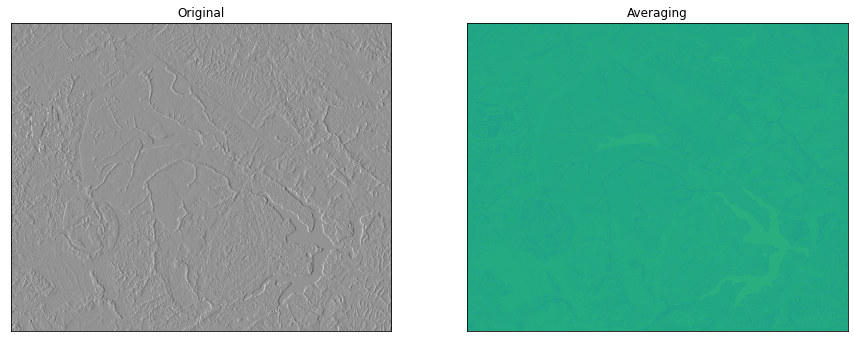

In [ ]:

img = tif.imread('/content/drive/MyDrive/Curso PDI com Python/L71221071_07120010720_DN.tif')
ndvi = (img[:,:,3] - img[:,:,2]) / (img[:,:,3] + img[:,:,2])
kernel1 = np.matrix([[1,1,1],[1,1,1],[1,1,1]])
kernel = np.matrix([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
kernel2 = np.matrix([[0,-1,0],[-1,5,-1],[0,-1,0]])
kernel3 = np.ones((13,13),np.float32)
filtrado = cv2.filter2D(ndvi,-1,kernel)
sobelx = cv2.Sobel(src=ndvi, ddepth=-1,  dx=1, dy=0, ksize=5) 
sobely = cv2.Sobel(src=ndvi, ddepth=-1, dx=0, dy=1, ksize=5)
#img_blur = cv2.GaussianBlur(img, (23,23), 0)

#f = convolve(img, kernel,mode='same', method='fft')
plt.figure(figsize=(15,10))
plt.subplot(121),plt.imshow(sobelx, cmap='Greys_r'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(filtrado, cmap='viridis_r'),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
img.shape

(1233, 1520)

In [ ]:
f.reshape(img.shape).shape

(1233, 1520, 4)

ImageView object:
  Display bands       :  [0, 2.0, 3]
  Interpolation       :  <default>
  RGB data limits     :
    R: [65.19999694824219, 255.0]
    G: [71.23999786376953, 255.0]
    B: [80.87999725341797, 255.0]

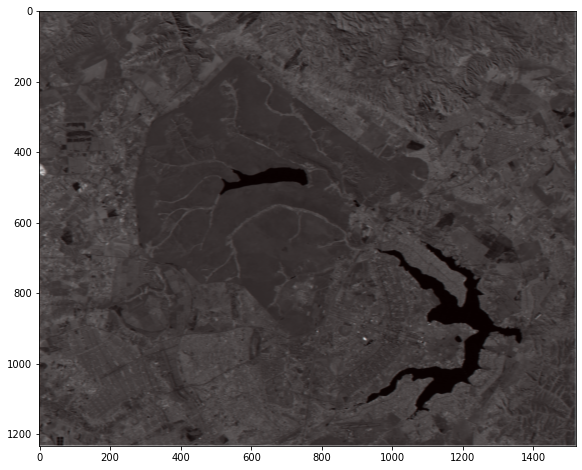

In [ ]:
imshow(f.reshape(img.shape), figsize=(12,8))

In [ ]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import rescale
import skimage.color as color
from tifffile import imsave
      

In [ ]:
m = tiff.imread('/content/drive/MyDrive/Live PDI Python/CBERS4/cut.tif')
pan = tiff.imread('/content/drive/MyDrive/Live PDI Python/CBERS4/pan_cut.tif')
print ('m_shape: ', m.shape)
print ('pan_shape: ', pan.shape)

m_shape:  (635, 700, 4)
pan_shape:  (2546, 2805)


In [ ]:
def stretch(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands)
    for i in range(3):
        a = 0 
        b = 255 
        c = np.percentile(bands[:,:,i], lower_percent)
        d = np.percentile(bands[:,:,i], higher_percent)        
        t = a + (bands[:,:,i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        out[:,:,i] =t
    return out.astype(np.uint8)

In [ ]:
def pansharpen(m, pan, method='browley', W=0.1, all_data=False):
    
    # get m_bands
    rgbn = np.empty((m.shape[0], m.shape[1], 4)) 
    rgbn[:,:,0] = m[:,:,0] # red
    rgbn[:,:,1] = m[:,:,1] # green
    rgbn[:,:,2] = m[:,:,2] # blue
    rgbn[:,:,3] = m[:,:,3] # NIR-1
    
    # scaled them
    rgbn_scaled = np.empty((m.shape[0]*4, m.shape[1]*4, 4))

    for i in range(4):
        img = rgbn[:,:,i]
        scaled = rescale(img, (4,4))
        rgbn_scaled[:,:,i] = scaled
    
    # check size and crop for pan band
    if pan.shape[0] < rgbn_scaled.shape[0]:
        rgbn_scaled = rgbn_scaled[:pan.shape[0],:, :]
    else:
        pan = pan[:rgbn_scaled.shape[0], :]
        
    if pan.shape[1] < rgbn_scaled.shape[1]:
        rgbn_scaled = rgbn_scaled[:,:pan.shape[1], :]
    else:
        pan = pan[:,:rgbn_scaled.shape[1]]

    R = rgbn_scaled[:,:,0]
    G = rgbn_scaled[:,:,1]
    B = rgbn_scaled[:,:,2]
    I = rgbn_scaled[:,:,3]
   
    image = None

    if method == 'simple_browley':
        all_in = R+G+B
        prod = np.multiply(all_in, pan)

        r = np.multiply(R, pan/all_in)[:, :, np.newaxis]
        g = np.multiply(G, pan/all_in)[:, :, np.newaxis]
        b = np.multiply(B, pan/all_in)[:, :, np.newaxis]

        image = np.dstack([r,g,b])
    
    if method == 'sample_mean':
        r = 0.5 * (R + pan)[:, :, np.newaxis]
        g = 0.5 * (G + pan)[:, :, np.newaxis]
        b = 0.5 * (B + pan)[:, :, np.newaxis]
        
        image = np.dstack([r,g,b])
        
    if method == 'esri':
        ADJ = pan-rgbn_scaled.mean(axis=2) 
        r = (R + ADJ)[:, :, np.newaxis]
        g = (G + ADJ)[:, :, np.newaxis]
        b = (B + ADJ)[:, :, np.newaxis]
        i = (I + ADJ)[:, :, np.newaxis]
        
        image = np.dstack([r,g,b,i])
    
    if method == 'browley':
        DNF = (pan - W*I)/(W*R+W*G+W*B)

        r = (R * DNF)[:, :, np.newaxis]
        g = (G * DNF)[:, :, np.newaxis]
        b = (B * DNF)[:, :, np.newaxis]
        i = (I * DNF)[:, :, np.newaxis]

        image = np.dstack([r,g,b,i])
    
    if method == 'hsv':
        hsv = color.rgb2hsv(rgbn_scaled[:,:,:3])
        hsv[:,:,2] = pan - I*W
        image = color.hsv2rgb(hsv)
        
    if all_data:
        return rgbn_scaled, image, I
    else:
        return image

In [ ]:
rgbn, sharpened_browley_simple, I = pansharpen(m, pan, method='simple_browley', all_data=True)
sharpened_mean = pansharpen(m, pan, method='sample_mean')
sharpened_esri = pansharpen(m, pan, method='esri')

sharpened_browley2 = pansharpen(m, pan, W=0.1)
sharpened_browley4 = pansharpen(m, pan, W=0.2)
sharpened_browley6 = pansharpen(m, pan, W=0.3)
sharpened_browley8 = pansharpen(m, pan, W=0.4)

sharpened_ihs2 = pansharpen(m, pan, method='hsv', W=0.1)
sharpened_ihs4 = pansharpen(m, pan, method='hsv', W=0.2)
sharpened_ihs6 = pansharpen(m, pan, method='hsv', W=0.3)
sharpened_ihs8 = pansharpen(m, pan, method='hsv', W=0.4)

ImageView object:
  Display bands       :  [0, 1, 2]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 446.5370650936383]
    G: [0.0, 421.90076129310796]
    B: [0.0, 475.00575757988736]

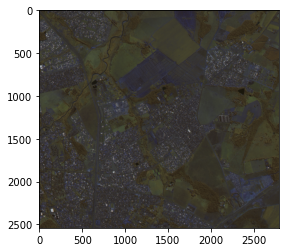

In [ ]:
imshow(sharpened_browley_simple)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


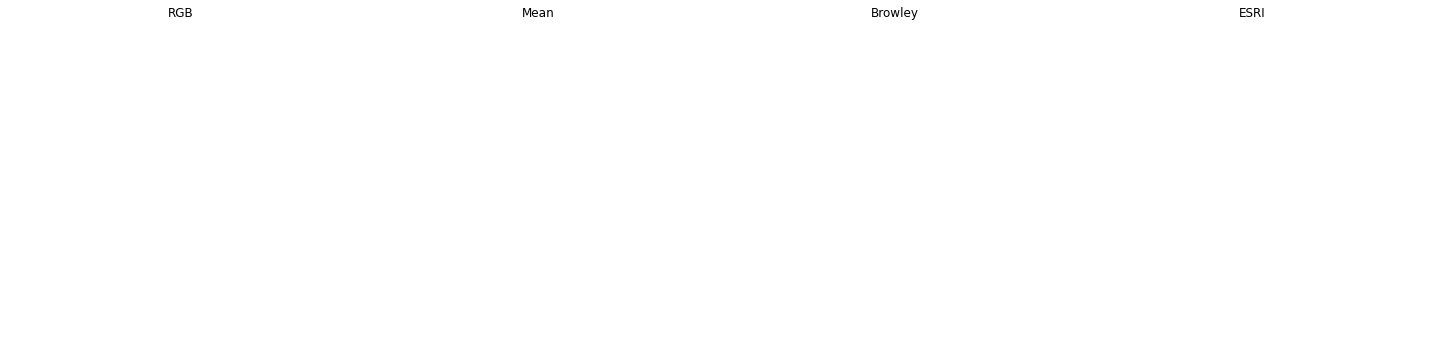

In [ ]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(20, 20))
ax = axes.ravel()

# no IR sharpening
'''ax[0].imshow(stretch(rgbn[500:1000,500:1000,:3]))
ax[0].set_title('RGB')
ax[0].axis('off')
ax[1].imshow(stretch(sharpened_mean[500:1000,500:1000,:]))
ax[1].set_title('Mean')    
ax[1].axis('off')
ax[2].imshow(stretch(sharpened_browley_simple[500:1000,500:1000,:]))
ax[2].set_title('Browley')
ax[2].axis('off')
ax[3].imshow(stretch(sharpened_esri[500:1000,500:1000,:3]))
ax[3].set_title('ESRI')
ax[3].axis('off')'''
ax[0].imshow(rgbn)
ax[0].set_title('RGB')
ax[0].axis('off')
ax[1].imshow(sharpened_mean)
ax[1].set_title('Mean')    
ax[1].axis('off')
ax[2].imshow(sharpened_browley_simple)
ax[2].set_title('Browley')
ax[2].axis('off')
ax[3].imshow(sharpened_esri)
ax[3].set_title('ESRI')
ax[3].axis('off')
plt.tight_layout()
plt.show()

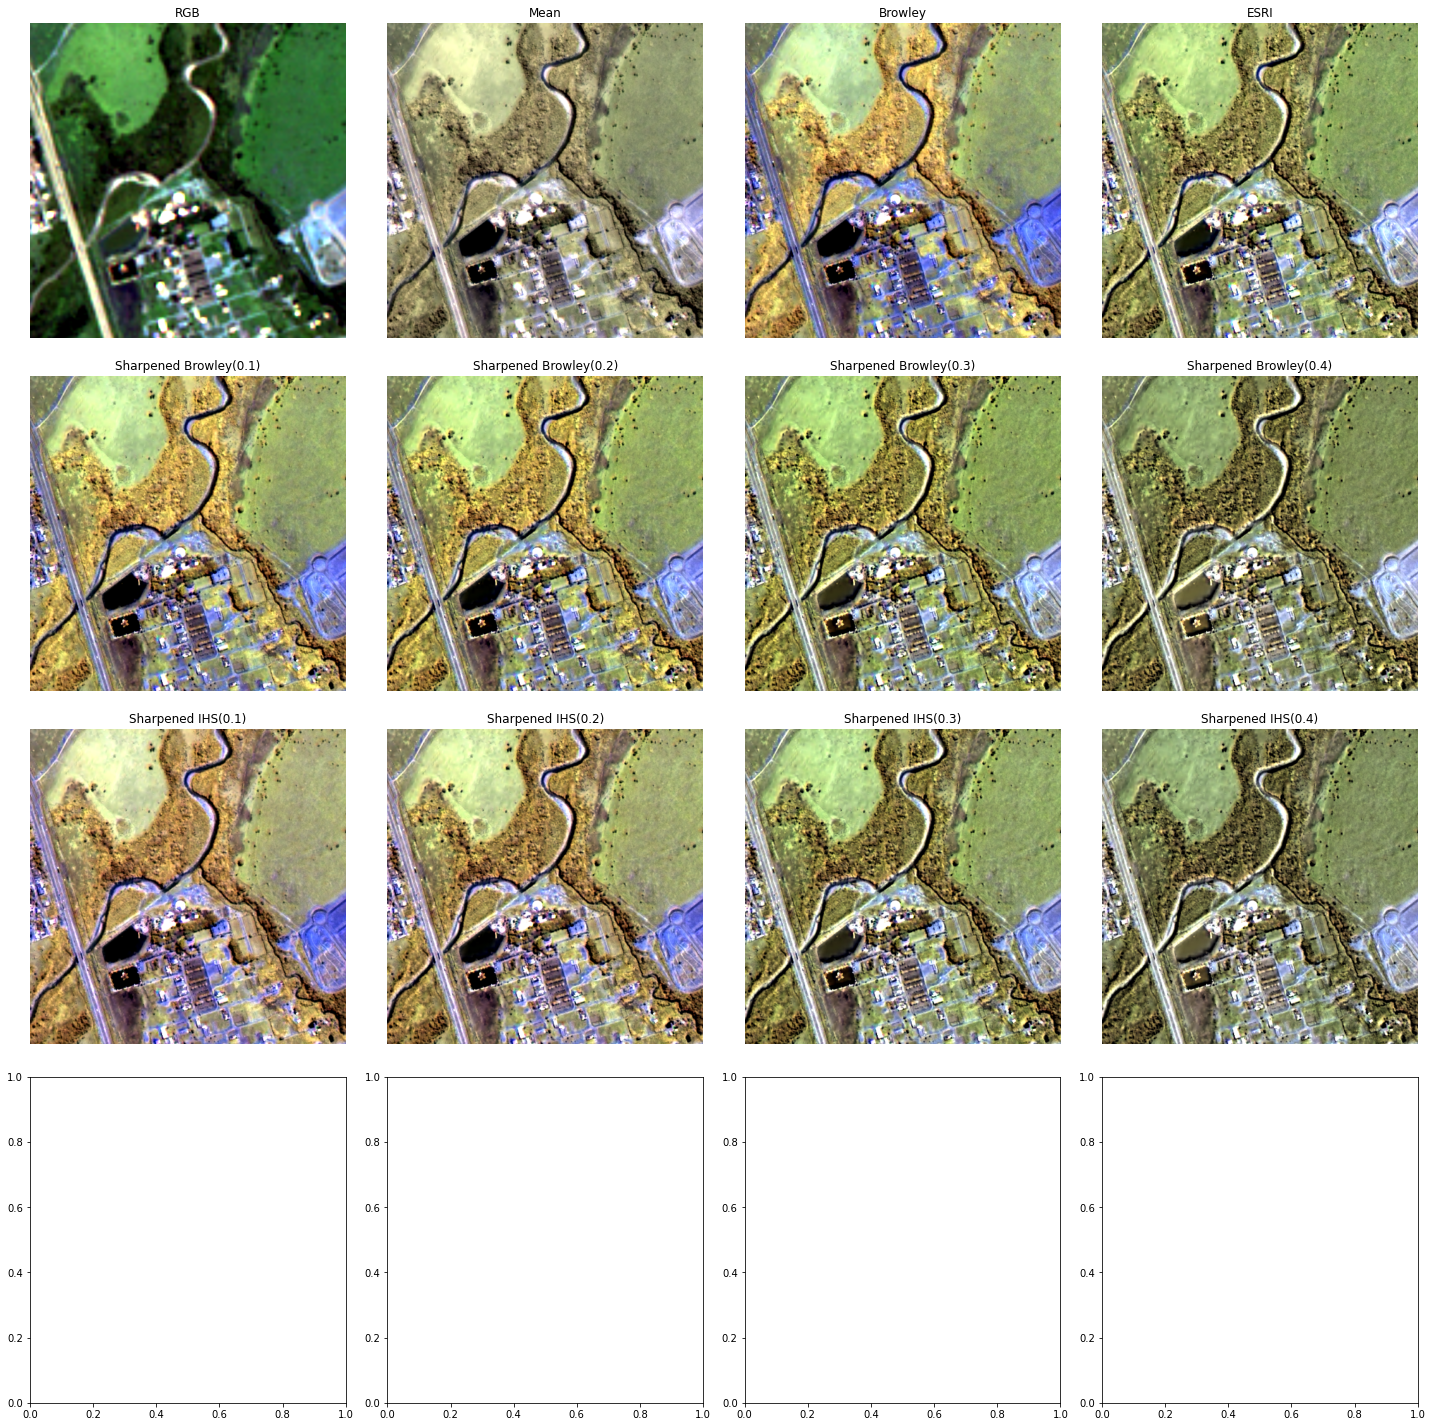

In [ ]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(20, 20))
ax = axes.ravel()

# no IR sharpening
ax[0].imshow(stretch(rgbn[500:1000,500:1000,:3]))
ax[0].set_title('RGB')
ax[0].axis('off')
ax[1].imshow(stretch(sharpened_mean[500:1000,500:1000,:]))
ax[1].set_title('Mean')    
ax[1].axis('off')
ax[2].imshow(stretch(sharpened_browley_simple[500:1000,500:1000,:]))
ax[2].set_title('Browley')
ax[2].axis('off')
ax[3].imshow(stretch(sharpened_esri[500:1000,500:1000,:3]))
ax[3].set_title('ESRI')
ax[3].axis('off')

# IR Browley
ax[4].imshow(stretch(sharpened_browley2[500:1000,500:1000,:3]))
ax[4].set_title('Sharpened Browley(0.1)')
ax[4].axis('off')
ax[5].imshow(stretch(sharpened_browley4[500:1000,500:1000,:3]))
ax[5].set_title('Sharpened Browley(0.2)')
ax[5].axis('off')
ax[6].imshow(stretch(sharpened_browley6[500:1000,500:1000,:3]))
ax[6].set_title('Sharpened Browley(0.3)')
ax[6].axis('off')
ax[7].imshow(stretch(sharpened_browley8[500:1000,500:1000,:3]))
ax[7].set_title('Sharpened Browley(0.4)')
ax[7].axis('off')

# IR HSV
ax[8].imshow(stretch(sharpened_ihs2[500:1000,500:1000,:3]))
ax[8].set_title('Sharpened IHS(0.1)')
ax[8].axis('off')
ax[9].imshow(stretch(sharpened_ihs4[500:1000,500:1000,:3]))
ax[9].set_title('Sharpened IHS(0.2)')
ax[9].axis('off')
ax[10].imshow(stretch(sharpened_ihs6[500:1000,500:1000,:3]))
ax[10].set_title('Sharpened IHS(0.3)')
ax[10].axis('off')
ax[11].imshow(stretch(sharpened_ihs8[500:1000,500:1000,:3]))
ax[11].set_title('Sharpened IHS(0.4)')
ax[11].axis('off')

plt.tight_layout()
plt.show()